# Emotion recognition from facial expressions

This project focuses on detecting facial expressions from images using machine-learning, specifically utilizing transfer learning with VGG16 and data augmentation. The goal is to preprocess facial image data, train a classification model that predicts the emotion displayed in the image, and evaluate its detection accuracy.

### Imports and dataset preparation

The dataset used for training is *FER-2013* from Kaggle (https://www.kaggle.com/datasets/msambare/fer2013) which consists of around 35.9 thousand (training and testing sets combined) 96x96 pixel greyscale images of faces. The faces display unique expressions classified into seven different emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral.

In this section, the dataset is loaded locally and split into training and validation sets from the already seperated train-folder. The testing set is loaded from the test-folder.

In [10]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
#os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow import keras
import matplotlib.pyplot as plt
import shutil, pathlib
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("./fer2013")

batch_size = 64
img_size = 96       # original image size (96x96)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "valid",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

num_classes = len(train_dataset.class_names)        # number of different emotions (classes)

Found 5741 files belonging to 7 classes.
Found 22968 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


The classes from each dataset are displayed to make sure their names and labels match correctly.

In [11]:
print(dict(enumerate(train_dataset.class_names)))
print(dict(enumerate(validation_dataset.class_names)))
print(dict(enumerate(test_dataset.class_names)))

{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'neutral', 5: 'sadness', 6: 'surprise'}
{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'neutral', 5: 'sadness', 6: 'surprise'}
{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


### Data augmentation and transfer learning

A data augmentation pipeline is defined to increase the diversity of the training data, helping the model generalize better and reduce overfitting. A pre-trained VGG16 convolutional neural network is loaded using ImageNet weights without the classification head. The convolutional base is then frozen to prevent the weights being updated during training.

In [12]:
# Define data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Load the pre-trained VGG16 model
conv_base = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size, img_size, 3)
)

# Freeze the convolutional base
conv_base.trainable = False

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Building the model

The model is defined with layers conisting of data augmentation, VGG16 preprocessing, rescaling, the convolutional base, `GlobalAveragePooling2D`, batch normalization, 128-neuron Dense-layer, and a dropout of 0.3, after which the output is received through softmax-activation.

In [13]:
inputs = keras.Input(shape=(img_size, img_size, 3))

x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = layers.Rescaling(1.0/255)(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 96, 96, 3) │          0 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 96, 96)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 96, 96)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 96, 96)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 96, 96, 3) │          0 │ get_item_3[0][0], │
│                     │                   │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 96, 96, 3) │          0 │ stack_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 96, 96, 3) │          0 │ add_1[0][0]       │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ rescaling_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │        903 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,783,303 (56.39 MB)

 Trainable params: 67,591 (264.03 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

### Compiling the model

The model is compiled using categorical cross-entropy as the loss function and the Adam optimizer with a learning rate of *1e-4*. A callback is configured to automatically save the best model checkpoint whenever validation loss improves.

In [14]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pre_fer2013_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

### Training the model

The model is trained on the training dataset while monitoring performance with the validation dataset. It is trained over only 10 epochs, as the model will be fine-tuned and trained for longer later on.

In [15]:
epochs = 10

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.2604 - loss: 1.9455 - val_accuracy: 0.3379 - val_loss: 1.6929
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3150 - loss: 1.7714 - val_accuracy: 0.3667 - val_loss: 1.6289
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3370 - loss: 1.7057 - val_accuracy: 0.3848 - val_loss: 1.5920
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3524 - loss: 1.6538 - val_accuracy: 0.3926 - val_loss: 1.5652
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3674 - loss: 1.6251 - val_accuracy: 0.4001 - val_loss: 1.5513
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3757 - loss: 1.6091 - val_accuracy: 0.4052 - val_loss: 1.5358
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3804 - loss: 1.5881 - val_accuracy: 0.4118 - val_loss: 1.5275
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3869 - loss: 1.5733 - 

### Testing the current performance

The best-performing model during training is loaded and evaluated using the testing set.

In [16]:
model = keras.models.load_model("pre_fer2013_model.keras")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy (pre-fine-tuned): {test_acc:.3f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4285 - loss: 1.4967
Test accuracy (pre-fine-tuned): 0.429


### Fine-tuning the model

The previously frozen VGG16 convolutional base is retrieved from the model and set to be trainable. This enables part of the pretrained model to adapt its feature representations to the facial-expression dataset.

In [17]:
base_model_layer = model.get_layer("vgg16")

base_model_layer.trainable = True

for layer in base_model_layer.layers[:-12]:
    layer.trainable = False

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 96, 96, 3) │          0 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 96, 96)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 96, 96)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 96, 96)    │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 96, 96, 3) │          0 │ get_item_3[0][0], │
│                     │                   │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 96, 96, 3) │          0 │ stack_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 96, 96, 3) │          0 │ add_1[0][0]       │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ rescaling_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │        903 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,918,487 (56.91 MB)

 Trainable params: 14,522,119 (55.40 MB)

 Non-trainable params: 261,184 (1020.25 KB)

 Optimizer params: 135,184 (528.07 KB)

### Training the fine-tuned model

The model is recompiled, now using a lower learning rate to enable fine tuning. It is trained over 30 epochs and its best-performing model is saved to be evaluated.

In [18]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks_finetuned = [
    keras.callbacks.ModelCheckpoint(
        filepath="fer2013_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

epochs_finetune = 25

history_finetune = model.fit(
    train_dataset,
    epochs=epochs_finetune,
    validation_data=validation_dataset,
    callbacks=callbacks_finetuned
)

Epoch 1/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.4462 - loss: 1.4543 - val_accuracy: 0.4983 - val_loss: 1.3168
Epoch 2/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.4960 - loss: 1.3177 - val_accuracy: 0.5327 - val_loss: 1.2255
Epoch 3/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.5257 - loss: 1.2442 - val_accuracy: 0.5496 - val_loss: 1.1824
Epoch 4/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.5491 - loss: 1.1907 - val_accuracy: 0.5727 - val_loss: 1.1250
Epoch 5/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.5606 - loss: 1.1591 - val_accuracy: 0.5776 - val_loss: 1.1244
Epoch 6/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.5779 - loss: 1.1206 - val_accuracy: 0.5952 - val_loss: 1.0781
Epoch 7/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.5876 - loss: 1.0919 - val_accuracy: 0.5945 - val_loss: 1.0876
Epoch 8/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.6004 - loss: 1.0607 - 

### Visualizing training history

The model's training (and validation) history is visualized to better understand the learning process.

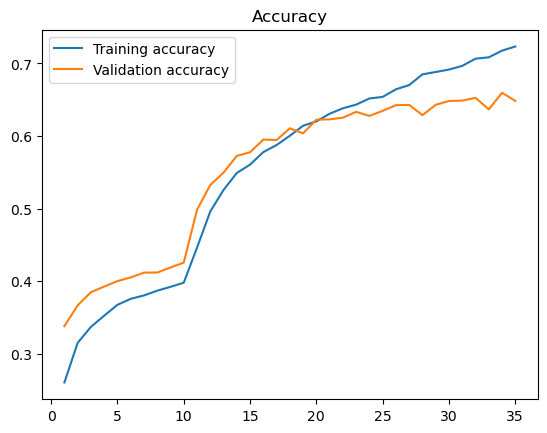

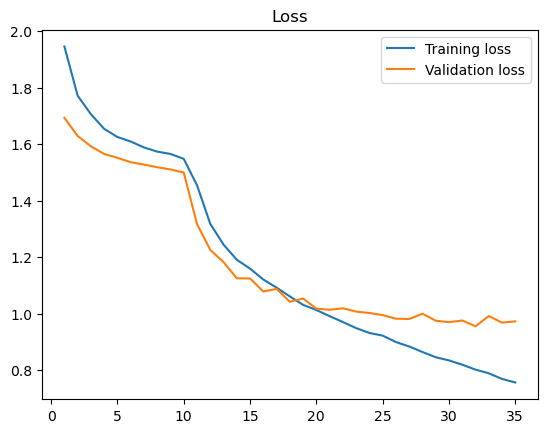

In [19]:
acc = history.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history.history["loss"] + history_finetune.history["loss"]
val_loss = history.history["val_loss"] + history_finetune.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.legend()
plt.title("Accuracy")

plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.title("Loss")
plt.show()

As seen in the graphs, there is a huge spike after 10 epochs - when it was fine-tuned and continued to be trained. The model reaches excellent accuracy overall considering the expected outcome from the dataset used for training. However, validation accuracy stops increasing and its loss stops decreasing after around 30 total epochs, so further tuning and regularization of the model would be in order.

### Final evaluation

The best fine-tuned model is loaded and evaluated using the testing set.

In [20]:
model = keras.models.load_model("fer2013_model.keras")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Final test accuracy: {test_acc:.3f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6530 - loss: 0.9388
Final test accuracy: 0.653


## Visualizing heatmaps of class activation

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import pathlib
import random
from PIL import Image, ImageOps

In [22]:
new_base_dir = pathlib.Path("./fer2013")
TARGET_LAYER_NAME = "block4_conv3"
class_names = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [23]:
try:
    model
except NameError:
    print("Ladataan malli...")
    model = keras.models.load_model("fer2013_model.keras")

In [24]:
def get_gradcam_model(target_layer_name):
    vgg_layer = model.get_layer("vgg16")
    internal_conv_layer = vgg_layer.get_layer(target_layer_name)

    vgg_sub_model = keras.models.Model(
        inputs=vgg_layer.inputs,
        outputs=[internal_conv_layer.output, vgg_layer.output]
    )

    classifier_layers = []
    found_vgg = False
    for layer in model.layers:
        if layer.name == 'vgg16':
            found_vgg = True
            continue
        if found_vgg:
            classifier_layers.append(layer)

    return vgg_sub_model, classifier_layers

vgg_sub_model, classifier_layers = get_gradcam_model(TARGET_LAYER_NAME)


In [25]:
def make_gradcam_heatmap(img_array, class_index=None):
    img_tensor = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        # A) Esikäsittely
        x = keras.applications.vgg16.preprocess_input(tf.identity(img_tensor))
        x = x * (1.0 / 255.0)

        # B) VGG-vaihe
        conv_outputs, vgg_output = vgg_sub_model(x, training=False)

        # C) Luokittelija-vaihe
        x_out = vgg_output
        for layer in classifier_layers:
            x_out = layer(x_out, training=False)

        predictions = x_out

        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)

    # Normalisointi
    max_val = tf.math.reduce_max(heatmap)
    if max_val == 0:
        max_val = 1e-10
    heatmap /= max_val

    # SÄÄTÖ: Poistetaan heikko kohina (alle 30%)
    heatmap = tf.where(heatmap < 0.3, 0.0, heatmap)

    return heatmap.numpy(), predictions.numpy(), int(class_index)

In [26]:
def preprocess_image_pil(img_path):
    # 1. Ladataan harmaasävyisenä
    img = load_img(img_path, color_mode='grayscale', target_size=(96, 96))

    # 2. Histogram Equalization (Korvaa CLAHE:n)
    # Tämä tasaa valoisuuserot ja tuo ilmeet esiin
    img_enhanced = ImageOps.equalize(img)

    # 3. Muutetaan RGB:ksi (VGG vaatii 3 kanavaa)
    # Koska kuva on grayscale, kopioimme saman kanavan 3 kertaa
    img_array = img_to_array(img_enhanced) # muoto (96, 96, 1)
    img_rgb_array = np.concatenate([img_array, img_array, img_array], axis=-1) # muoto (96, 96, 3)

    # Lisätään batch-ulottuvuus (1, 96, 96, 3)
    input_tensor = np.expand_dims(img_rgb_array, axis=0)

    return img_enhanced, input_tensor

def show_gradcam(img_path, alpha=0.5):
    # 1. Esikäsittely
    original_pil, img_tensor = preprocess_image_pil(img_path)

    # 2. Heatmap laskenta
    heatmap, preds, idx = make_gradcam_heatmap(img_tensor)
    predicted_label = class_names[idx]
    confidence = preds[0, idx]

    # 3. Heatmapin väritys (Matplotlib cm)
    # Skaalataan heatmap 0-255 välille
    heatmap_uint8 = np.uint8(255 * heatmap)

    # Haetaan värikartta (Jet)
    jet = cm.get_cmap("jet")

    # Luodaan RGBA värit ja otetaan vain RGB
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8] # (H, W, 3) float 0-1

    # 4. Skaalataan heatmap oikeaan kokoon (96x96)
    heatmap_img = array_to_img(jet_heatmap)
    heatmap_img = heatmap_img.resize((96, 96))
    heatmap_array = img_to_array(heatmap_img) / 255.0 # Normalisoidaan 0-1

    # 5. Yhdistetään alkuperäinen kuva ja heatmap
    original_array = img_to_array(original_pil) / 255.0
    original_rgb = np.concatenate([original_array, original_array, original_array], axis=-1)

    superimposed = (original_rgb * (1 - alpha)) + (heatmap_array * alpha)
    superimposed = np.clip(superimposed, 0, 1) # Varmistetaan ettei arvot ylitä 1.0

    # 6. Tulostus
    print(f"Kuva: {img_path}")
    print(f"Ennuste: {predicted_label} ({confidence:.2%})")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_pil, cmap='gray')
    axes[0].axis("off")
    axes[0].set_title("Syöte (Equalized)")

    axes[1].imshow(superimposed)
    axes[1].axis("off")
    axes[1].set_title(f"{predicted_label} ({confidence:.1%})\nLayer: {TARGET_LAYER_NAME}")

    plt.tight_layout()
    plt.show()


Todellinen luokka: fear
Kuva: Sorted_data/test/fear/image0004079.jpg
Ennuste: sad (49.91%)


/tmp/ipykernel_25140/3033709757.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


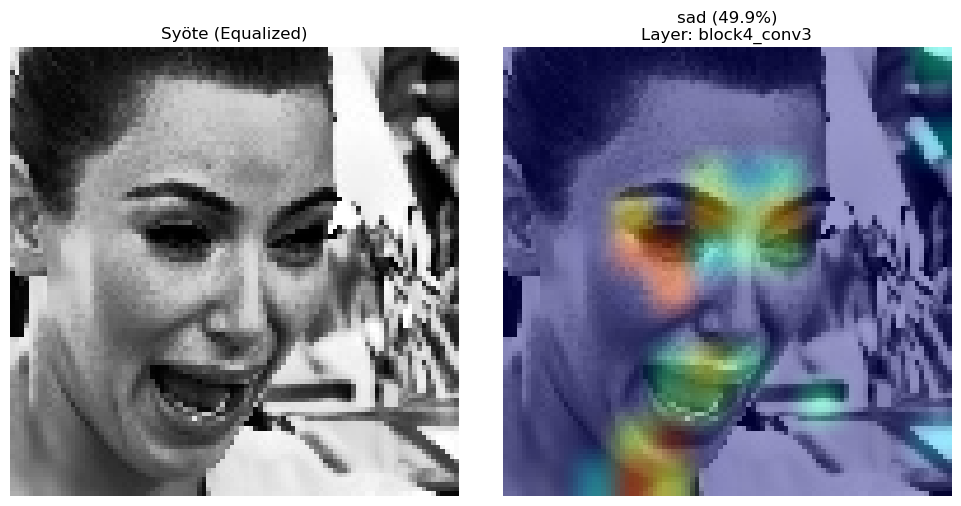

In [27]:
def run_test():
    try:
        test_root = new_base_dir / "test"
        all_dirs = [d for d in test_root.iterdir() if d.is_dir()]

        if not all_dirs:
            print("Kuvia ei löytynyt.")
            return

        random_dir = random.choice(all_dirs)
        all_images = [p for p in random_dir.iterdir() if p.is_file()]

        if all_images:
            img_path = str(random.choice(all_images))
            print(f"Todellinen luokka: {random_dir.name}")
            show_gradcam(img_path, alpha=0.4)
        else:
            print("Tyhjä kansio.")

    except Exception as e:
        print(f"Virhe: {e}")
        import traceback
        traceback.print_exc()

run_test()

Valittu kuva: Sorted_data/test/sadness/ffhq_1515.png
Todellinen luokka: sadness


/tmp/ipykernel_25140/4136556688.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


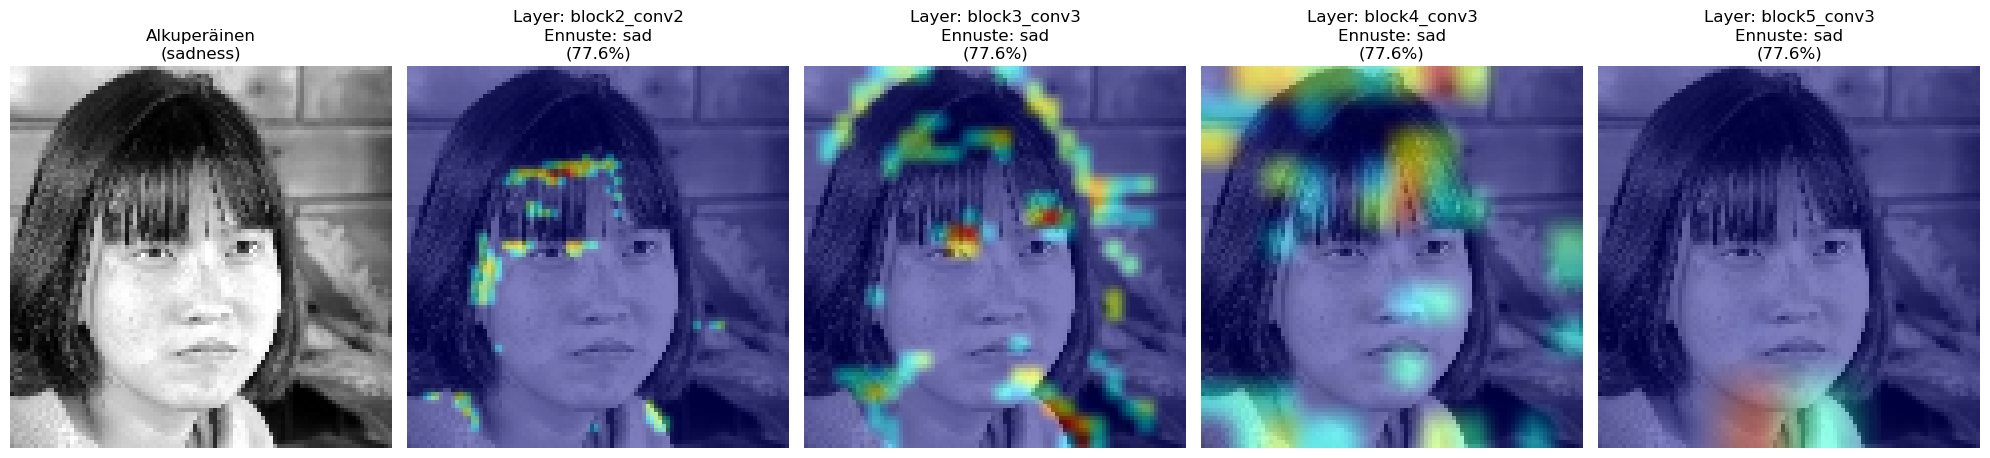

In [31]:
# Määritellään vertailtavat kerrokset (jokaisen lohkon viimeinen konvoluutiokerros)
layers_to_compare = ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

def compare_layers_heatmap():
    try:
        # 1. Valitaan yksi satunnainen kuva
        test_root = new_base_dir / "test"
        all_dirs = [d for d in test_root.iterdir() if d.is_dir()]
        random_dir = random.choice(all_dirs)
        all_images = [p for p in random_dir.iterdir() if p.is_file()]

        if not all_images:
            print("Kuvia ei löytynyt.")
            return

        img_path = str(random.choice(all_images))
        true_label = random_dir.name

        print(f"Valittu kuva: {img_path}")
        print(f"Todellinen luokka: {true_label}")

        # 2. Esikäsittely (tehdään kerran)
        original_pil, img_tensor = preprocess_image_pil(img_path)
        original_array = img_to_array(original_pil) / 255.0
        original_rgb = np.concatenate([original_array, original_array, original_array], axis=-1)

        # 3. Luodaan kuvaaja (1 rivi, 4 saraketta: Alkuperäinen + 3 heatmapia)
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))

        # Näytetään alkuperäinen kuva ensimmäisenä
        axes[0].imshow(original_pil, cmap='gray')
        axes[0].set_title(f"Alkuperäinen\n({true_label})")
        axes[0].axis("off")

        # 4. Loopataan kerrosten läpi
        # HUOM: Käytämme globaaleja muuttujia vgg_sub_model ja classifier_layers,
        # jotka make_gradcam_heatmap -funktio vaatii. Päivitämme ne loopissa.
        global vgg_sub_model, classifier_layers

        for i, layer_name in enumerate(layers_to_compare):
            # Päivitetään Grad-CAM malli käyttämään nykyistä kerrosta
            vgg_sub_model, classifier_layers = get_gradcam_model(layer_name)

            # Lasketaan heatmap
            heatmap, preds, idx = make_gradcam_heatmap(img_tensor)
            predicted_label = class_names[idx]
            confidence = preds[0, idx]

            # Visuaalinen prosessointi (sama kuin show_gradcam-funktiossa)
            heatmap_uint8 = np.uint8(255 * heatmap)
            jet = cm.get_cmap("jet")
            jet_colors = jet(np.arange(256))[:, :3]
            jet_heatmap = jet_colors[heatmap_uint8]

            heatmap_img = array_to_img(jet_heatmap).resize((96, 96))
            heatmap_array = img_to_array(heatmap_img) / 255.0

            # Yhdistetään kuvaan (alpha 0.5)
            alpha = 0.5
            superimposed = (original_rgb * (1 - alpha)) + (heatmap_array * alpha)
            superimposed = np.clip(superimposed, 0, 1)

            # Piirretään
            ax = axes[i+1]
            ax.imshow(superimposed)
            ax.axis("off")
            ax.set_title(f"Layer: {layer_name}\nEnnuste: {predicted_label}\n({confidence:.1%})")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Virhe vertailussa: {e}")
        import traceback
        traceback.print_exc()

# Ajetaan vertailu
compare_layers_heatmap()